In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


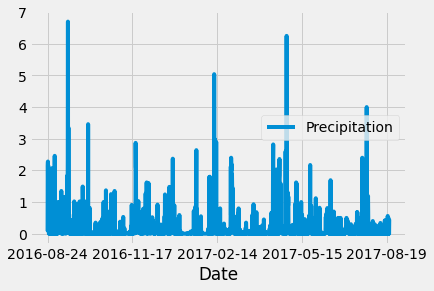

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date_first = session.query(Measurement.date).order_by(Measurement.date.asc()).first().date
date_first
date_last = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
date_last

date_1_year_from_last = dt.datetime.strptime(date_last, '%Y-%m-%d') - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
last_year_rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_1_year_from_last).order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_rain, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)
df = df.dropna()
df
# Sort the dataframe by date
df=df.sort_values(by='Date', ascending=True)
# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot().get_figure()
ax.savefig("Precipitation_last_12months.png")

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).distinct().count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_count=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
Most_Active_Station=stations_count[0][0]
stations_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == Most_Active_Station).all()
print(f"{Most_Active_Station}")
print(f" Lowest recorded temperature (F)  : {Results[0][0]}")
print(f" Highest recorded temperature (F) : {Results[0][1]}")
print(f" Avg recorded temperature (F): {round(Results[0][2],2)}")

USC00519281
 Lowest recorded temperature (F)  : 54.0
 Highest recorded temperature (F) : 85.0
 Avg recorded temperature (F): 71.66


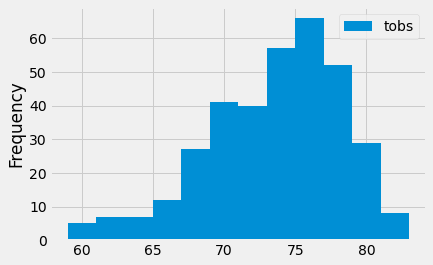

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Last_year_for_Most_Active_station = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == Most_Active_Station).filter(Measurement.date >= date_1_year_from_last).group_by(Measurement.date).all()
Last_year_for_Most_Active_station_df = pd.DataFrame(data=Last_year_for_Most_Active_station, columns=["date", "tobs"])
Last_year_for_Most_Active_station_df = Last_year_for_Most_Active_station_df.set_index('date', drop=True)
ax=Last_year_for_Most_Active_station_df.plot(kind="hist",bins=12).get_figure()
ax.savefig("Histogram.png")

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_year=2022
last_data_year=2017

my_trip_arrival = dt.date(my_trip_year, 1, 1)
my_trip_leave = dt.date(my_trip_year, 1, 10)

previous_years_arrival=dt.date(last_data_year, 1, 1)
previous_years_leave=dt.date(last_data_year, 1, 10)


# calculate the min/max/avg from last year that matches my trip date
data = calc_temps(previous_years_arrival,previous_years_leave)
data

[(60.0, 68.0327868852459, 77.0)]

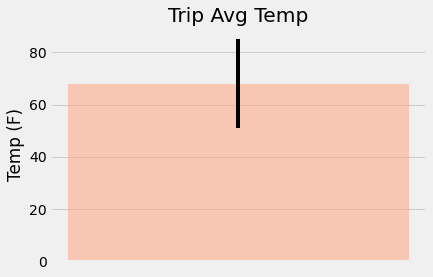

In [25]:
# Plot the results from your previous query as a bar chart. 
holiday_temp_df = pd.DataFrame(data=data, columns=["tmin", "tavg", "tmax"])
holiday_temp_df["date"]=my_trip_arrival
holiday_temp_df = holiday_temp_df.set_index('date', drop=True)
plot_date = holiday_temp_df.index.values
plot_tmin = holiday_temp_df['tmin']
plot_tavg = holiday_temp_df['tavg']
plot_tmax = holiday_temp_df['tmax']




# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
# Use the average temperature for the y value

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
difference = holiday_temp_df['tmax'] - holiday_temp_df['tmin']

bar=plt.bar(plot_date, plot_tavg, yerr=difference, color="lightsalmon", alpha=.5, label="Error Bar is Max-Min")

plt.ylabel('Temp (F)')
plt.xticks([],[])
plt.savefig("Bar_Chart.png")
plt.show()

In [46]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trip_locations_results=session.query(Station.station,
                  Station.name,
                  Station.latitude,
                  Station.longitude,
                  Station.elevation,
                  func.sum(Measurement.prcp))\
.filter(Measurement.station == Station.station)\
.filter(Measurement.date >= previous_years_arrival)\
.filter(Measurement.date <= previous_years_leave)\
.group_by(Station.station)\
.order_by(func.sum(Measurement.prcp).desc()).all()

df=pd.DataFrame(data=trip_locations_results, columns=["station_id","station_name","lat","long","elevation","precipitation_amount"])
df['precipitation_amount'] = df['precipitation_amount'].replace(np.nan, 0)
#df=df["prcp"]+0
df=df.sort_values(by='precipitation_amount', ascending=True)

df

,station_id,station_name,lat,long,elevation,precipitation_amount
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.63
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.63


In [47]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [62]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`


# Set the start and end date of the trip
my_trip_arrival
my_trip_leave
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(my_trip_arrival, my_trip_leave)

# Stip off the year and save a list of %m-%d strings
trip_mmdd = trip_dates.strftime('%m-%d')
trip_mmdd

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for trip_date in trip_mmdd:
    normals_list.append(*daily_normals(trip_date))

normals_list

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0)]

In [53]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['date'] = trip_dates
normals_df = normals_df.set_index('date')

normals_df

,Tmin,Tavg,Tmax
date,,,
2022-01-01,62.0,69.153846,77.0
2022-01-02,60.0,69.396226,77.0
2022-01-03,62.0,68.909091,77.0
2022-01-04,58.0,70.000000,76.0
2022-01-05,56.0,67.964286,76.0
2022-01-06,61.0,68.964912,76.0
2022-01-07,57.0,68.543860,76.0
2022-01-08,57.0,67.160714,75.0
2022-01-09,58.0,67.929825,78.0


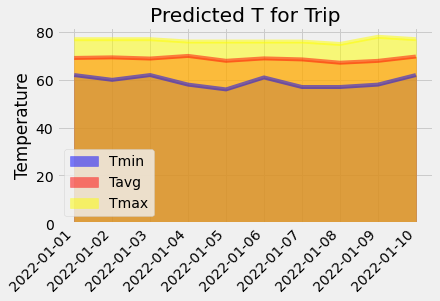

In [61]:
# Plot the daily normals as an area plot with `stacked=False`

colors = ['blue', 'red', 'yellow']

normals_df.plot(kind='area', stacked=False, x_compat=True, color=colors, alpha=.5, title='Predicted T for Trip', rot=45)
plt.xlabel('')
plt.ylabel('Temperature')
plt.savefig("Daily_Normals.png")
plt.show()